### ЧАСТЬ I

In [1419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline


используемые функции:

In [1420]:
def search_d(dt, start_d=1, end_d=4):
    d = start_d
    while d < end_d+1:
        otg_i_diff = dt.diff(periods=d).dropna()
        test = adfuller(otg_i_diff)
        if test[0]>test[4]['5%']:
            d+=1
        else:
            break
    return f'Ряд стационарен при d = {d}'


def stat_test(data):

    test = adfuller(data)

    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']:
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

In [1421]:
data = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
data["GDP"] = data["GDP"].astype(float)
data.index = pd.to_datetime(data.index)
data

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


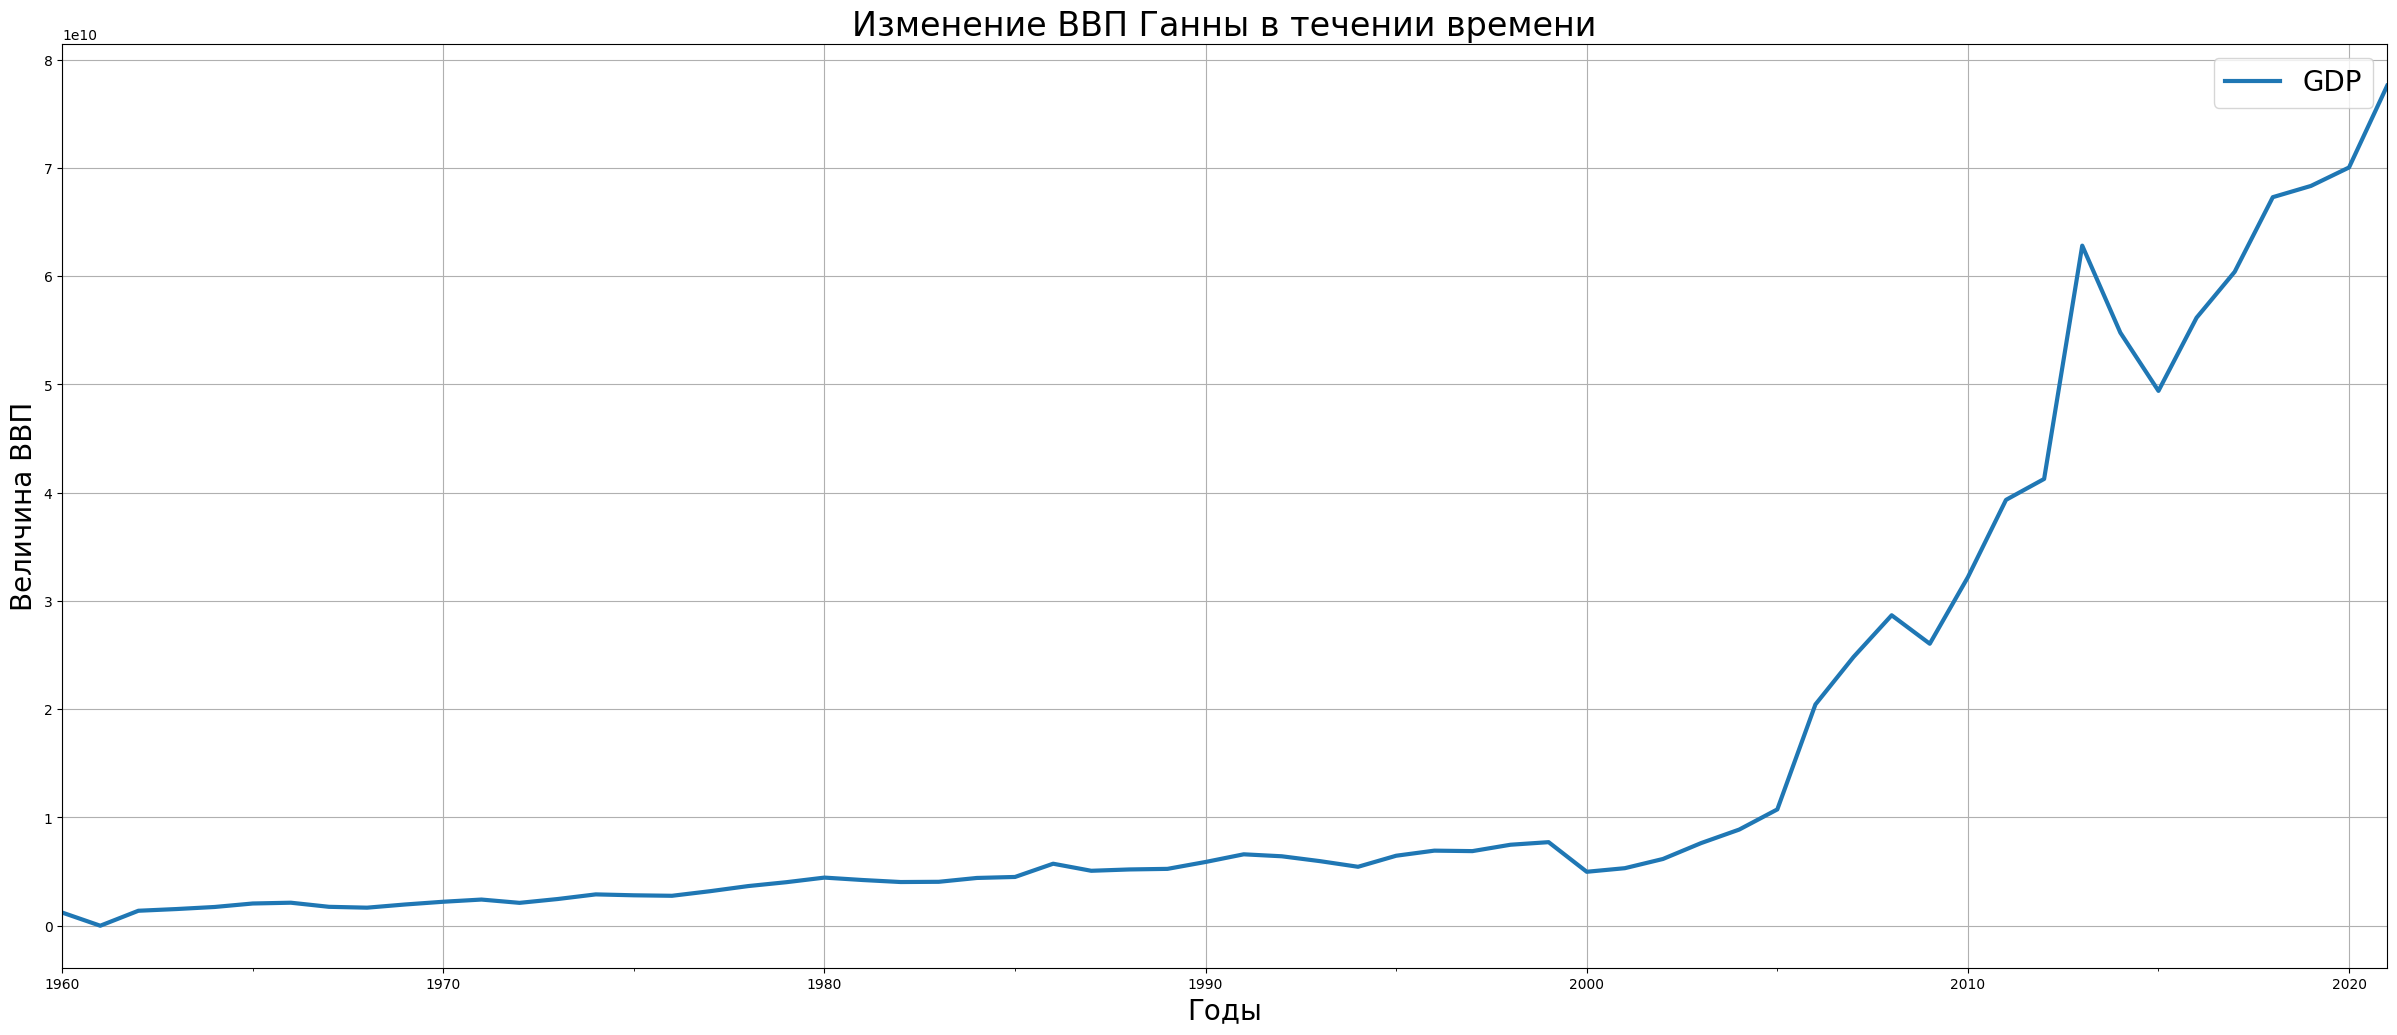

In [1422]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot(legend=True,
    title='Изменение ВВП Ганны в течении времени',
    grid=True,
    xlabel='Годы',
    ylabel='Величина ВВП')
plt.show()

вопрос 1

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде. 

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

Вывод: 

На графике видно, что тренд возрастающий на всем продяжении, но начиная с 2000 года рост стремительно увеличился. Сезонность не просматривается.

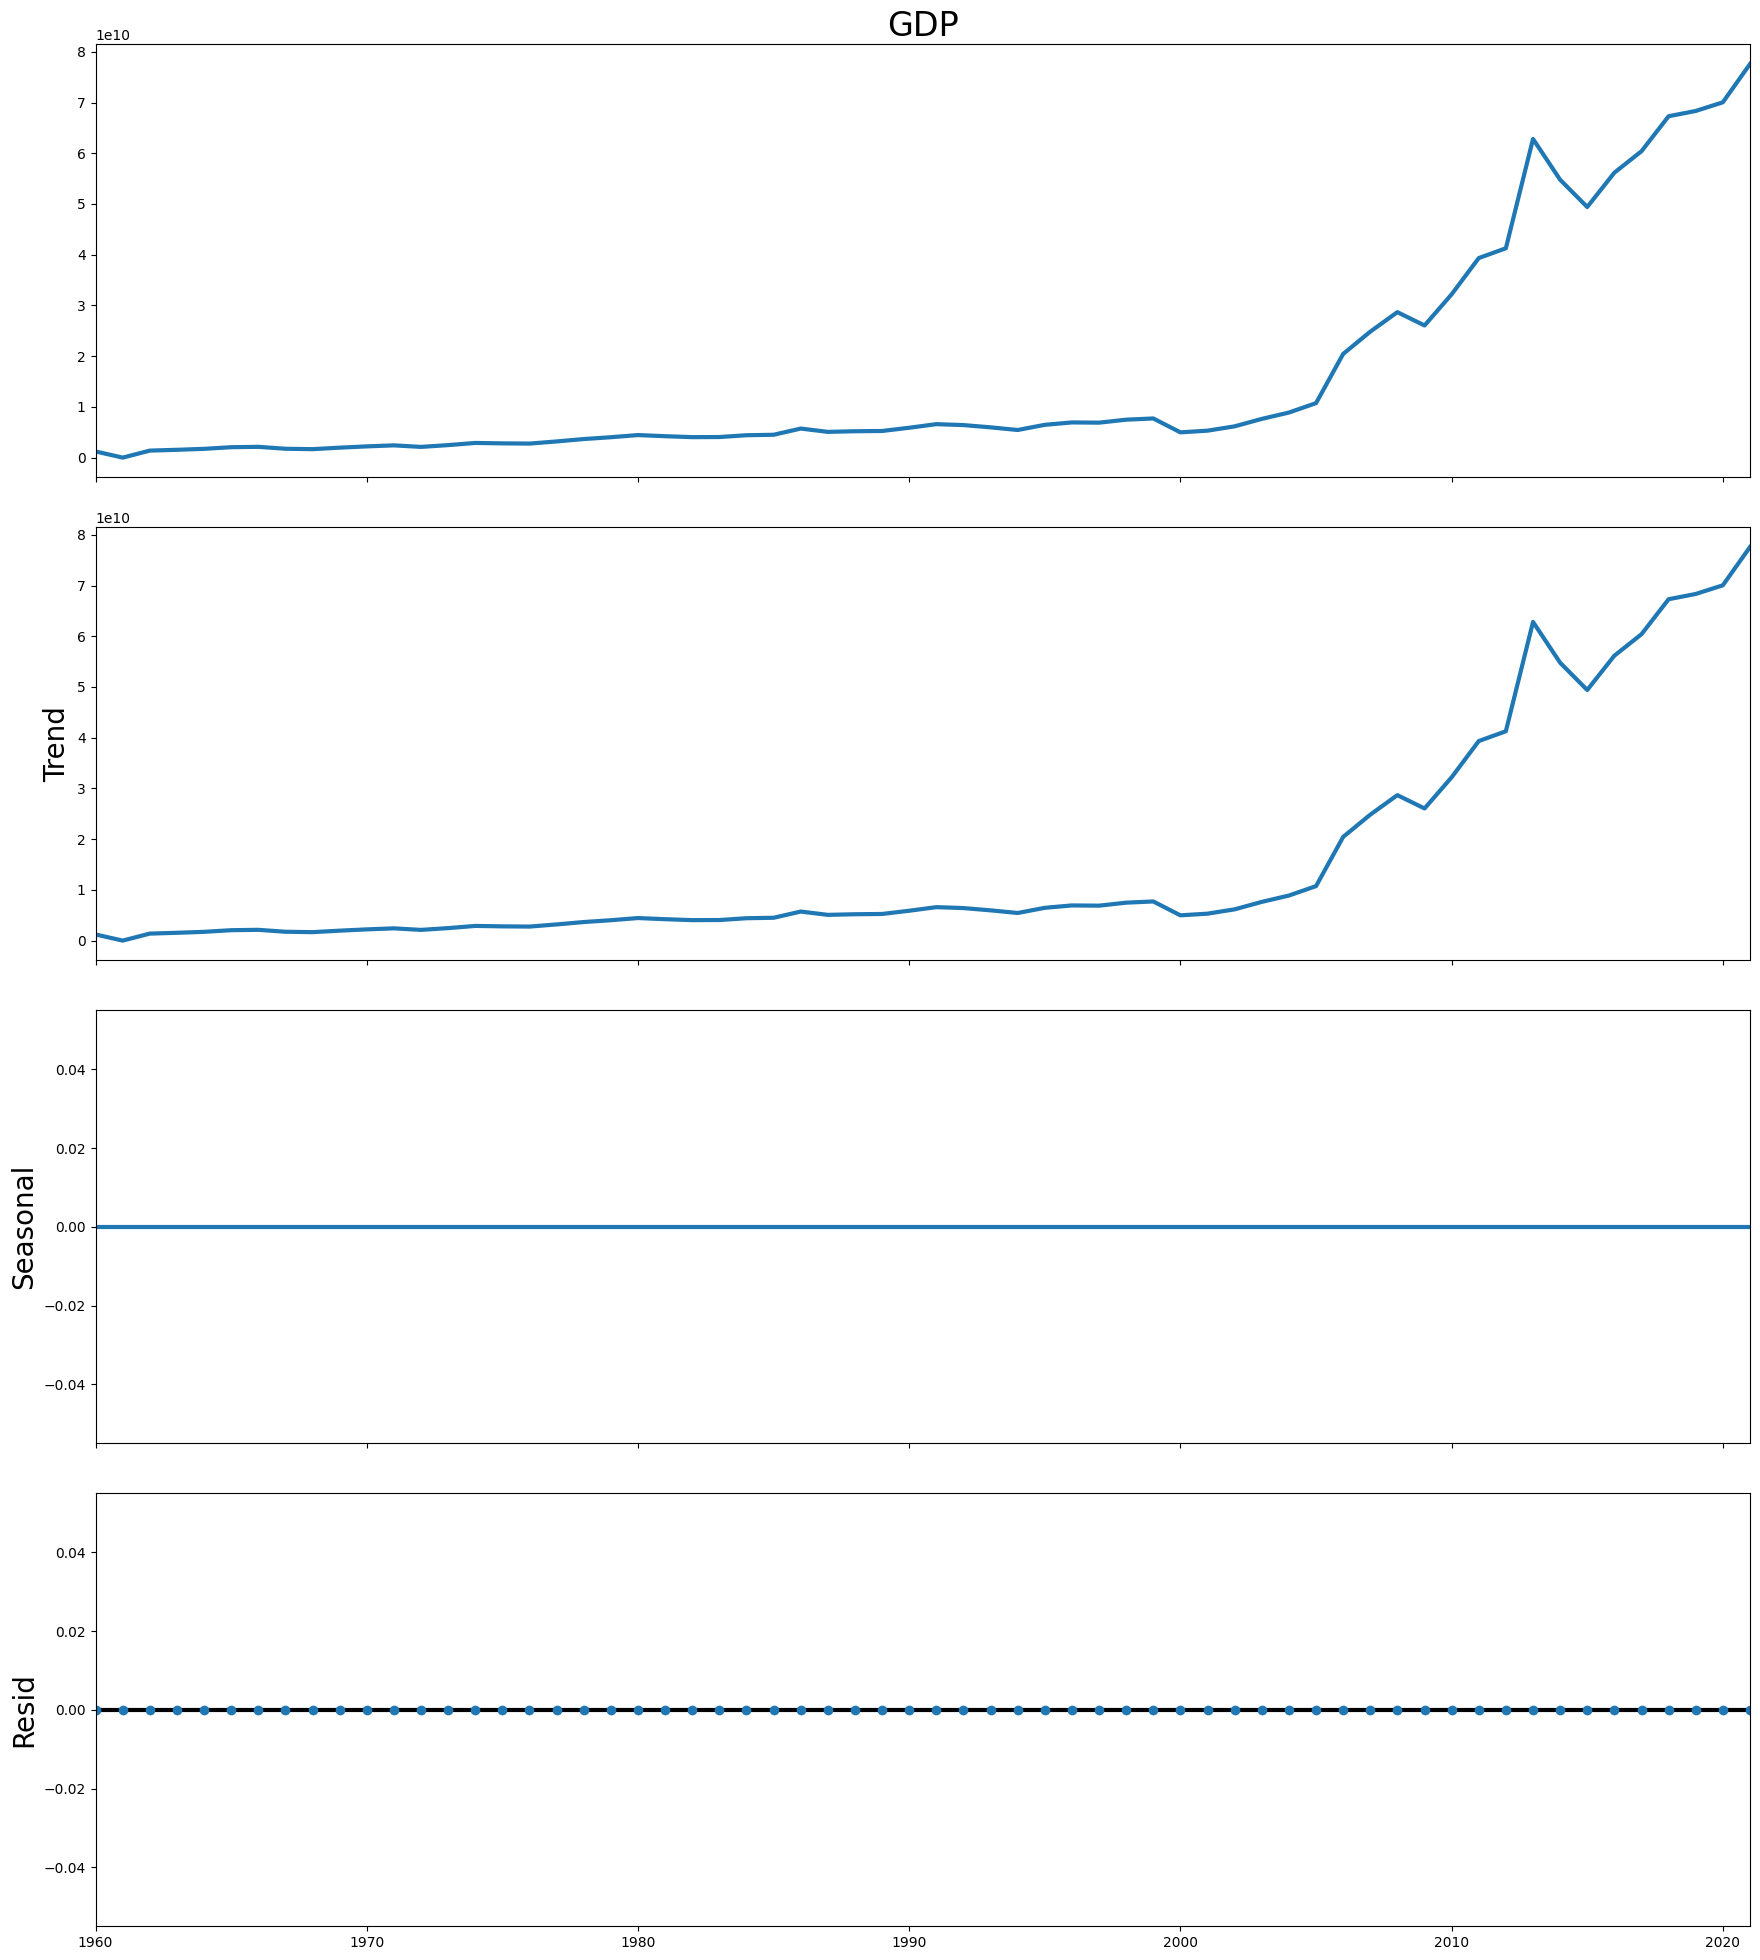

In [1423]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(data["GDP"])
result.plot()
plt.show()

Разделим данные на тренировочную и тестовую выборки в соответствии с заданием

In [1424]:
data_train = data.iloc[:-3]
data_test = data.iloc[-3:]
data_train.shape, data_test.shape

((59, 1), (3, 1))

вопрос 2

Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

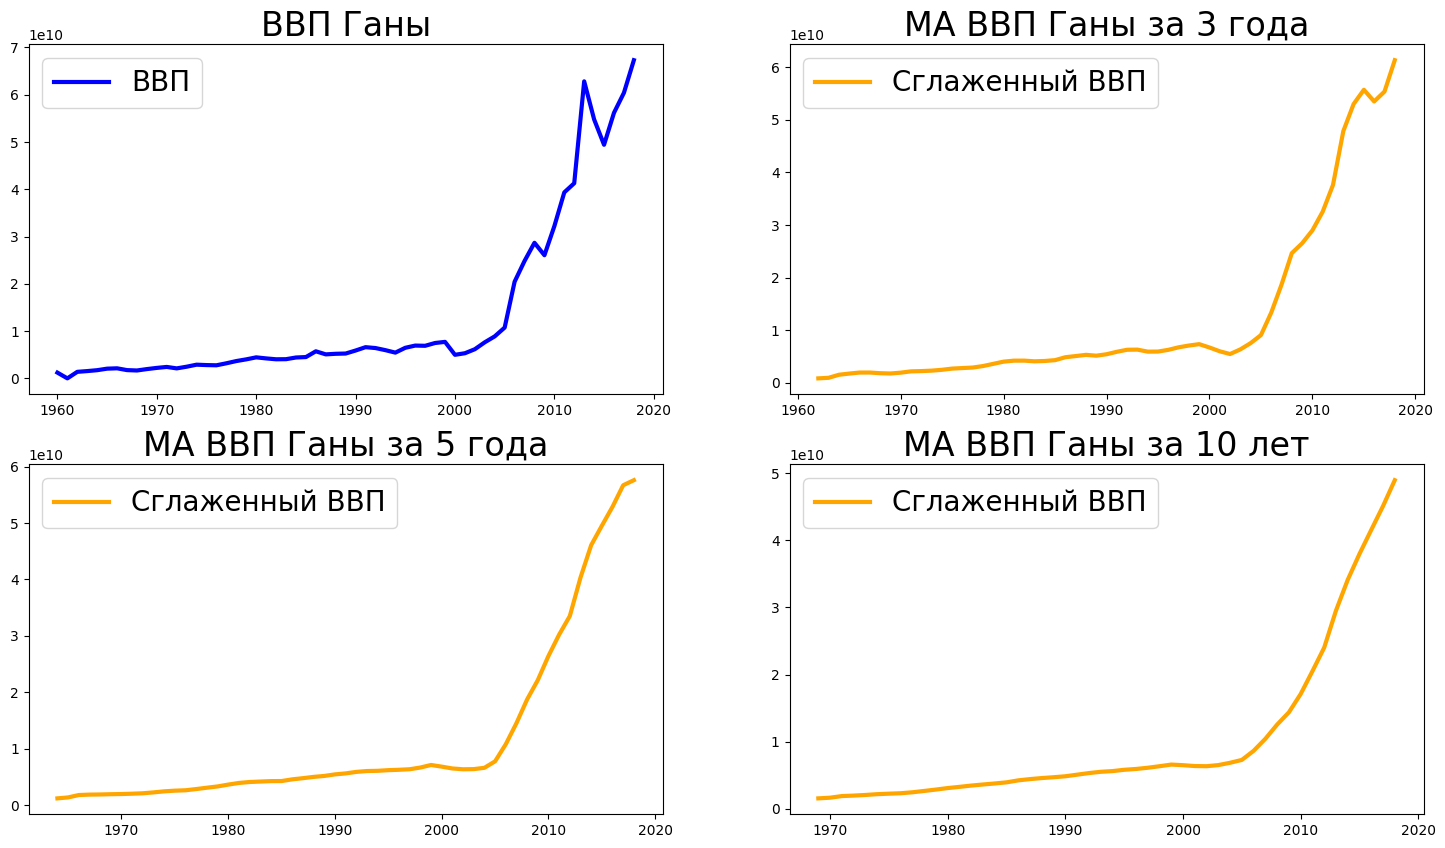

In [1425]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(data_train.GDP, color="blue", label="ВВП")
ax[0, 0].set_title("ВВП Ганы", size=24)
ax[0, 0].legend()

# Окно в месяц (Window = 3)
ax[0, 1].plot(
    data_train.GDP.rolling(window=3).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[0, 1].set_title("MA ВВП Ганы за 3 года", size=24)
ax[0, 1].legend()

# Окно в месяц (Window = 5)
ax[1, 0].plot(
    data_train.GDP.rolling(window=5).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 0].set_title("MA ВВП Ганы за 5 года", size=24)
ax[1, 0].legend()

# Окно в год (Window = 10)
ax[1, 1].plot(
    data_train.GDP.rolling(window=10).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 1].set_title("MA ВВП Ганы за 10 лет", size=24)
ax[1, 1].legend()

plt.show()

Чем меньше окно сдвига MA, тем больше модель реагирует на выборсы. Оптимальнее использовать не очень маленькие и не очень большие значения окна, описываающие изменение показателя без "скачков" и "рывков", например, 10.

Вопрос 3

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [1426]:
# С помощью функции проверим ряд на стационарность
stat_test(data_train)

adf:  0.652906697488536
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен.


Статистика теста больше всех критических значений, поэтому нулевую гипотезу (
) нельзя отвергнуть.

Следовательно, ряд не стационарен и будем применять модель ARIMA.

In [1427]:
# С помощью функции определим значение d для модели ARIMA
search_d(data_train['GDP'])

'Ряд стационарен при d = 2'

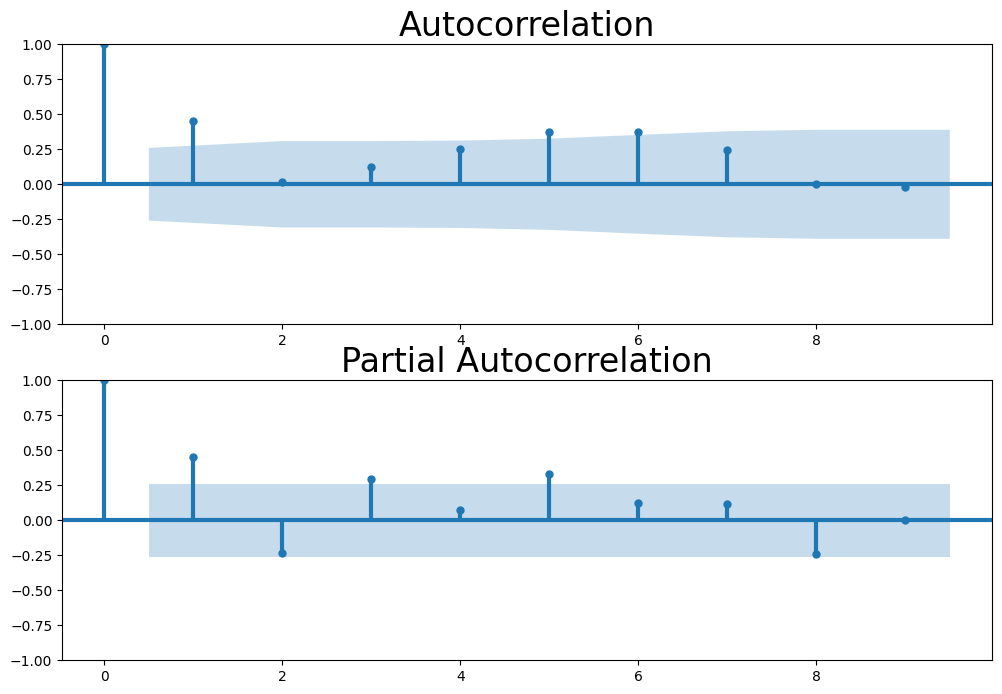

In [1428]:
# Определяем параметры p и q по коррелограммам ACF и PACF для стационарного ряда.
otg_2_diff = data_train.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff, lags=9, ax=ax2)

Судя по коррелограммам q = 1 (по графику автокорреляции), p = 5 (по графику частичной автокорреляции).

In [1429]:
# Построим модель ARIMA для прогнозирования поведения временного ряда
arima_model = ARIMA(data_train['GDP'].dropna(), order=(5, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.756
Date:                 Сб, 04 янв 2025   AIC                           2677.512
Time:                        10:41:12   BIC                           2691.813
Sample:                    01-01-1960   HQIC                          2683.070
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7719      0.374     -2.066      0.039      -1.504      -0.040
ar.L2         -0.7874      0.359     -2.192      0.028      -1.492      -0.083
ar.L3         -0.6264      0.387     -1.617      0.106      -1.385       0.133
ar.L4         -0.7573      0.314     -2.415      0.016      -1.372      -0.143
ar.L5         -0.3846      0.356     -1.079      0.281      -1.083       0.314
ma.L1         -0.3606      0.386     -0.934      0.351      -1.118       0.396
sigma2      1.285e+19   1.26e-20   1.02e+39      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               203.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             175.02   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+55. Standard errors may be unstable.
"""

Критерий Акаике (AIC) равен 2677.512

Проведем подбор параметров при помощи pamdarima

In [1430]:
# Попытаемся подобрать наилучшие параметры p и q с помощью пакета `pmdarima`
pamdarima_model = pm.auto_arima(
    data_train['GDP'],
    start_p=1,
    d=1,
    start_q=1,
    max_p=6,
    max_d=3,
    max_q=2,
    D=1,
    start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

pamdarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2732.043, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2728.025, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2729.982, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2730.117, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2730.972, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.059 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1362.013
Date:                 Сб, 04 янв 2025   AIC                           2728.025
Time:                        10:41:12   BIC                           2732.146
Sample:                    01-01-1960   HQIC                          2729.631
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.139e+09   5.02e+08      2.270      0.023    1.56e+08    2.12e+09
sigma2      1.461e+19      0.176   8.28e+19      0.000    1.46e+19    1.46e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               451.60
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              34.65   Skew:                             2.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Лучшее значение критерия Акаике 2728.025 при p = 0, d = 1, q = 0, найденных пакетом pmdarima.

С параметрами определенными с помощью коррелограмм (p = 5, d = 2, q = 1), критерий Акаике равен 2677.512, что ниже предыдещего, а значит лучше.

Вопрос 4

Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [1431]:
# Построим модель с лучшими параметрами (p = 5, d = 2, q = 1) и выполним предсказание для тестовой выборки.

pred_data = pd.DataFrame(index=data.index)

arima_model_best = ARIMA(data_train['GDP'].dropna(), order=(5, 2, 1))
arima_model_best_fit = arima_model_best.fit()


pred_data['model_pred'] = arima_model_best_fit.predict(
    start=data_test.index[0], end=data_test.index[-1]
)


pred_data['GDP'] = data['GDP']

forecast = arima_model_best_fit.get_forecast(len(data_test.index))
forecast_data = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_data.at[data_test.index, 'model_pred_lower'] = forecast_data['lower GDP']
pred_data.at[data_test.index, 'model_pred_upper'] = forecast_data['upper GDP']

In [1432]:
pred_data

,model_pred,GDP,model_pred_lower,model_pred_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.665709e+10,6.833754e+10,6.963159e+10,8.368259e+10


Вопрос 5

Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

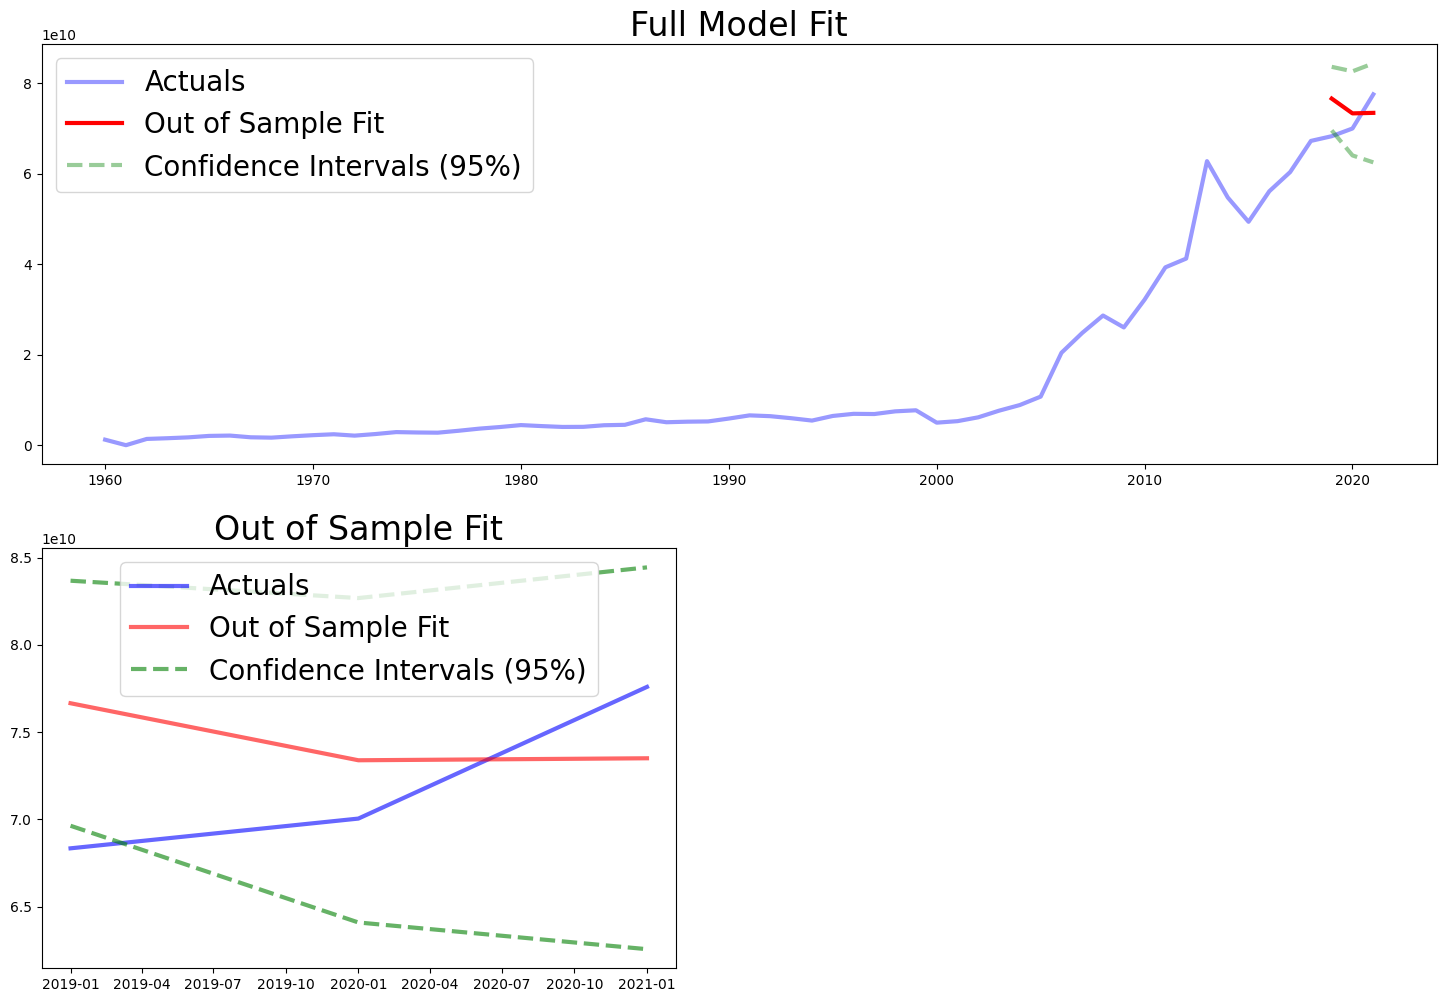

In [1433]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_data["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_data.loc[data_test.index]["model_pred"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_data.loc[data_test.index]["model_pred_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_data.loc[data_test.index]["model_pred_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_data.loc[data_test.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_data.loc[data_test.index]["model_pred"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_data.loc[data_test.index]["model_pred_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_data.loc[data_test.index]["model_pred_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [1434]:
# Рассчитаем MAPE-ошибку
(mean_absolute_percentage_error(list(pred_data.loc[data_test.index]["GDP"]),
                                 list(pred_data.loc[data_test.index]['model_pred']))*100).round()

7.0

Вывод: Лучше всех предсказывает модель, выбранная по оптимальным параметрам с помощью auto_arima (0,1,0). Модель отработала хорошо - ошиблась на 7 % от истинного значения.

### ЧАСТЬ II

Вопрос 1

Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.
Подсказка
df.asfreq(freq='AS')

In [1435]:
print('Записей до обработки пропусков с помощью метода asfreq: {}.'.format(
    data.shape[0]))
data = data.asfreq(freq='AS')
print('Записей после обработки пропусков с помощью метода asfreq: {}.'.format(
    data.shape[0]))

Записей до обработки пропусков с помощью метода asfreq: 62.
Записей после обработки пропусков с помощью метода asfreq: 62.


Количество записей не изменилось. Пропусков в данных не было

Вопрос 2

Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [1436]:
data.isna().sum()

GDP    0
dtype: int64

Пропусков со значение NaN нет.

Впорсм 3

Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

import numpy as np

df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [1437]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x == 0 else x)
data.isna().sum()

GDP    1
dtype: int64

После приравнивания значения 0 к пропуску, появился 1 пропуск.

Вопрос 4

Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

Подсказка

df['GDP (current US$)'].interpolate(method='linear')

In [1438]:
interpolated_data = pd.DataFrame(data['GDP'].interpolate(method='linear'))
interpolated_data

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Вопрос 4

Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [1439]:
data_train_int = interpolated_data.iloc[:-3]
data_test_int = interpolated_data.iloc[-3:]
data_train_int.shape, data_test_int.shape

((59, 1), (3, 1))

In [1440]:
# С помощью функции проверим ряд на стационарность
stat_test(data_train_int)

adf:  0.8030073326980126
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен.


Статистика теста больше всех критических значений, поэтому нулевую гипотезу (
) нельзя отвергнуть.

Следовательно, ряд не стационарен и будем применять модель ARIMA.

In [1441]:
# Определим значение d для модели ARIMA
search_d(data_train_int['GDP'])

'Ряд стационарен при d = 2'

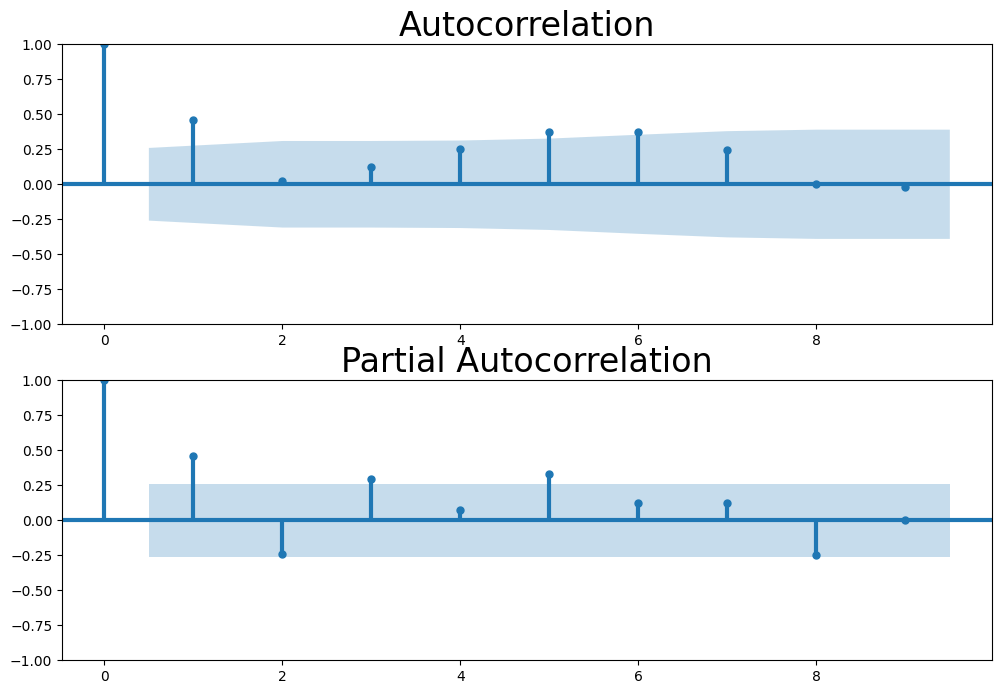

In [1442]:
otg_2_diff = data_train_int.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff, lags=9, ax=ax2)

Судя по коррелограммам q = 1 (по графику автокорреляции), p = 5 (по графику частичной автокорреляции).

In [1443]:
# Построим модель ARIMA для прогнозирования поведения временного ряда
arima_model_int = ARIMA(data_train_int['GDP'].dropna(), order=(5, 2, 1))
arima_model_fit_int = arima_model_int.fit()
arima_model_fit_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.694
Date:                 Сб, 04 янв 2025   AIC                           2677.389
Time:                        10:41:13   BIC                           2691.690
Sample:                    01-01-1960   HQIC                          2682.947
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7694      0.375     -2.052      0.040      -1.504      -0.035
ar.L2         -0.7892      0.360     -2.194      0.028      -1.494      -0.084
ar.L3         -0.6258      0.389     -1.607      0.108      -1.389       0.137
ar.L4         -0.7573      0.315     -2.400      0.016      -1.376      -0.139
ar.L5         -0.3818      0.358     -1.068      0.286      -1.083       0.319
ma.L1         -0.3596      0.388     -0.926      0.354      -1.121       0.402
sigma2      1.282e+19   1.33e-20   9.64e+38      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               208.08
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             287.04   Skew:                             1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.22e+55. Standard errors may be unstable.
"""

Критерий Акаике (AIC) равен 2677.389

Вопрос 5

Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

Вывод: ПРОВЕРИТЬ
Показатель критерия Акаике в построенной модели незначительно изменился в лучшую сторону (на 0.123) по сравнению с моделью неинтерполированных данных. Незначительное улучшение связано с тем, что в данных был только один пропуск в начале временного ряда (за 1961 год).

### ЧАСТЬ III

ЗАДАНИЕ 8.3

Вопрос 1

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

Пример кода:

tscv = TimeSeriesSplit(...)

2. Выведите размеры полученных подвыборок:

train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [1444]:
tscv = TimeSeriesSplit(n_splits=3, test_size=3)
train_test_groups = tscv.split(interpolated_data) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 53 TEST size: 3
TRAIN size: 56 TEST size: 3
TRAIN size: 59 TEST size: 3


Вопрос 1.

Посчитайте волатильность для вашего временного ряда.

In [1445]:
interpolated_data['vol'] = interpolated_data.pct_change(1).mul(100).abs()
interpolated_data


,GDP,vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


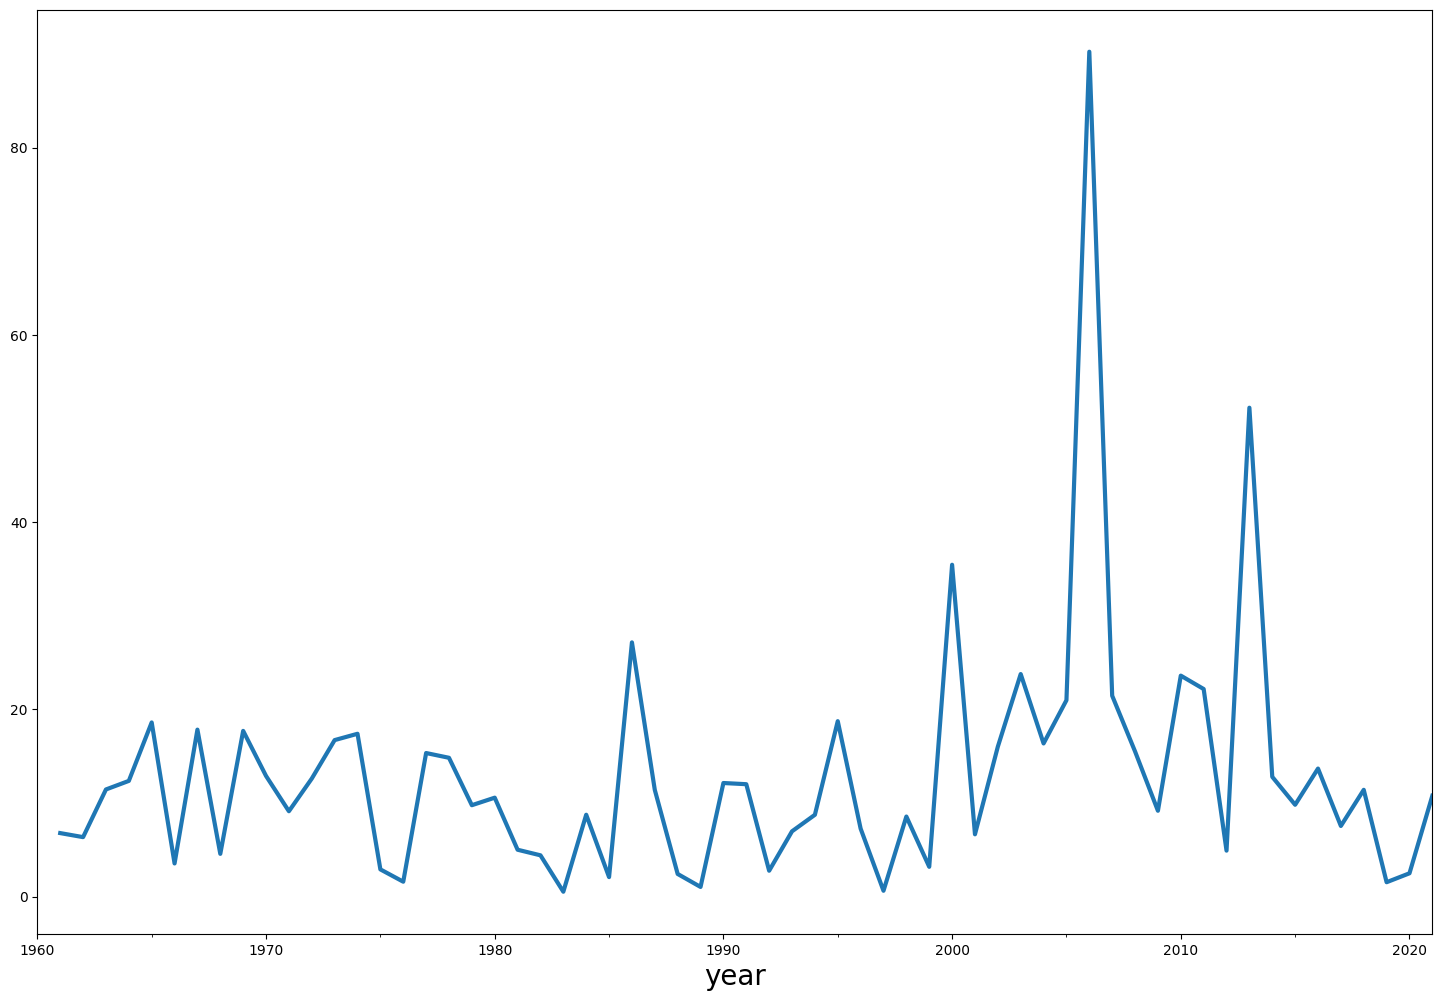

In [1446]:
interpolated_data['vol'].plot()
plt.show()

In [1447]:
interpolated_data

,GDP,vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


Разделим данные на тренировочную и тестовую выборку.

In [1448]:
data_train_int_vol = interpolated_data.iloc[:-3]
data_test_int_vol = interpolated_data.iloc[-3:]
data_train_int_vol.shape, data_test_int_vol.shape

((59, 2), (3, 2))

Оценим стационарность данных по волатильности:

In [1449]:
stat_test(data_train_int_vol.vol[1:])

adf:  -6.725311059553778
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Единичных корней нет, ряд стационарен.


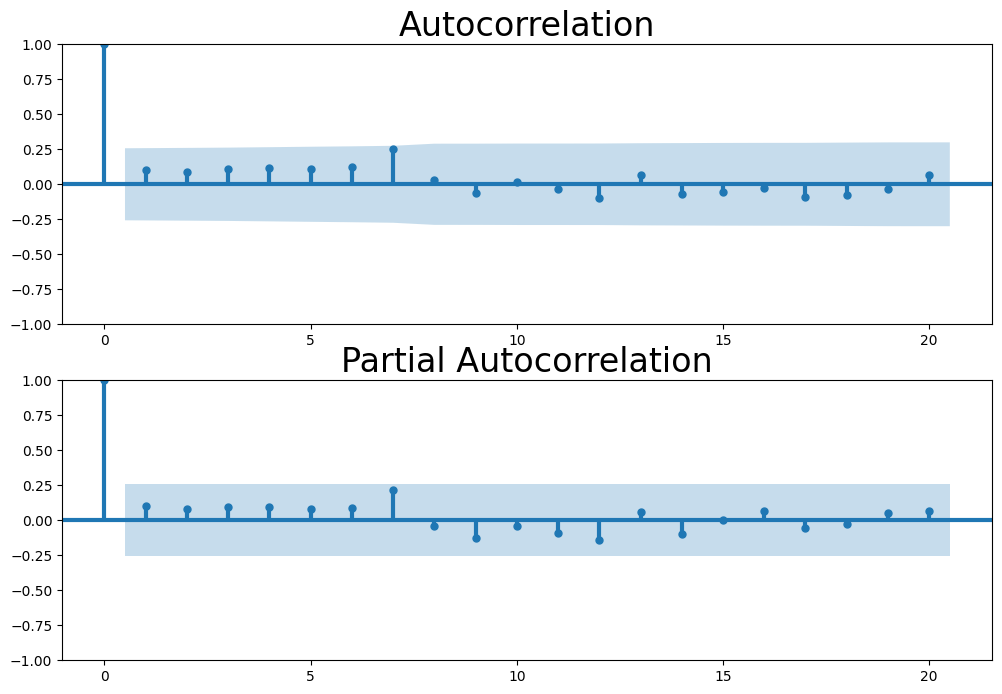

In [1450]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train_int_vol.vol[1:].values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train_int_vol.vol[1:], lags=20, ax=ax2)

Глядя на графики ACF и PACF для волатильности, мы не можем явно определить самый значительный лаг. В таком случае выьерем параметры p и q равными единице. Итак, мы построим модель GARCH(1, 1).

In [1451]:
garch_df = pd.DataFrame(interpolated_data["vol"].loc[interpolated_data.index])
garch_df.loc[data_train_int_vol.index, "vol"] = data_train_int_vol["vol"].dropna()

model_arch = arch_model(garch_df["vol"].dropna(), p=1, q=1, vol='GARCH')

model_results_arch = model_arch.fit(last_obs=data_test_int_vol.index[0], update_freq=1)
model_results_arch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                 Сб, янв 04 2025   Df Residuals:                       57
Time:                        10:41:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

Создадим датасет с предсказаниями:

In [1452]:
model_results_arch

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                 Сб, янв 04 2025   Df Residuals:                       57
Time:                        10:41:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.36

In [1453]:
predictions_df_arch = data_test_int_vol.copy()
predictions_df_arch["Predictions"] = model_results_arch.forecast().residual_variance.loc[data_test_int_vol.index]
predictions_df_arch

,GDP,vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,288.546011
2020-01-01,7.004320e+10,2.495937,292.216032
2021-01-01,7.759428e+10,10.780603,295.886053


Визуализируем прогноз и реальные данные:

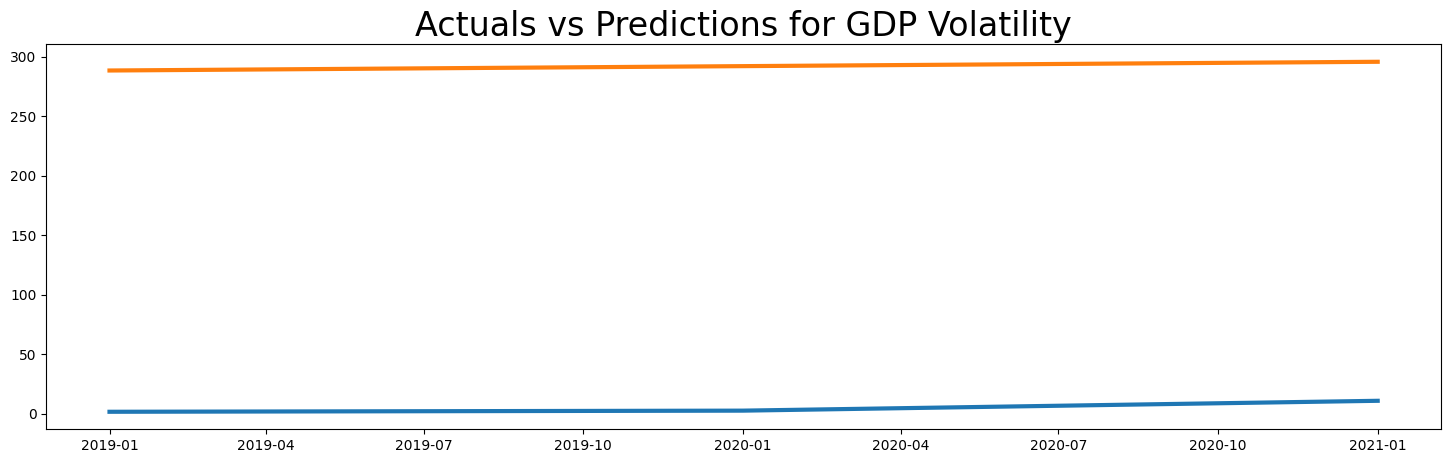

In [1454]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df_arch["vol"].abs())
plt.plot(predictions_df_arch["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

Модель сильно ошиблась в предсказании. Зафиксируем значение среднеквадратичной ошибки.

In [1455]:
mean_squared_error(
    predictions_df_arch["vol"].abs(), predictions_df_arch["Predictions"]
)

82531.24159419035

Вопрос 3.

Используйте линейную регрессию для получения прогноза.

Попробуем использовать модель линейной регрессии в этом случае:

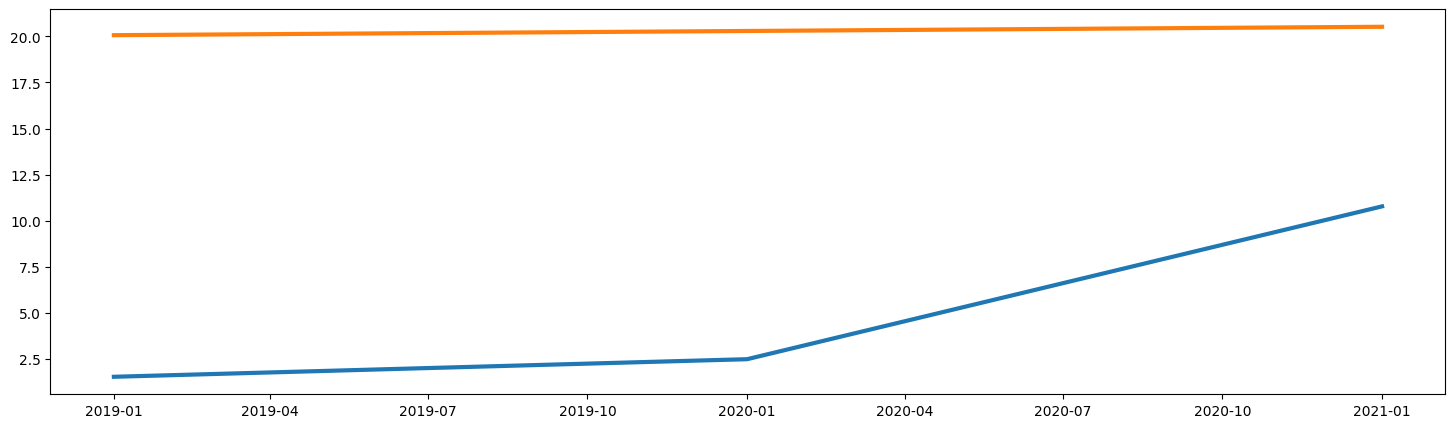

In [1456]:
X_train = pd.DataFrame(range(interpolated_data["vol"].shape[0]))[
    : data_train_int_vol.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(interpolated_data["vol"].shape[0]))[
    data_train_int_vol.shape[0] :
].fillna(0)
y_train = data_train_int_vol["vol"].fillna(0)
y_test = data_test_int_vol["vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Вопрос 4. 

Визуализируйте полученное предсказание вместе с фактическим значением.

Визуализируем все результаты на одном графике:

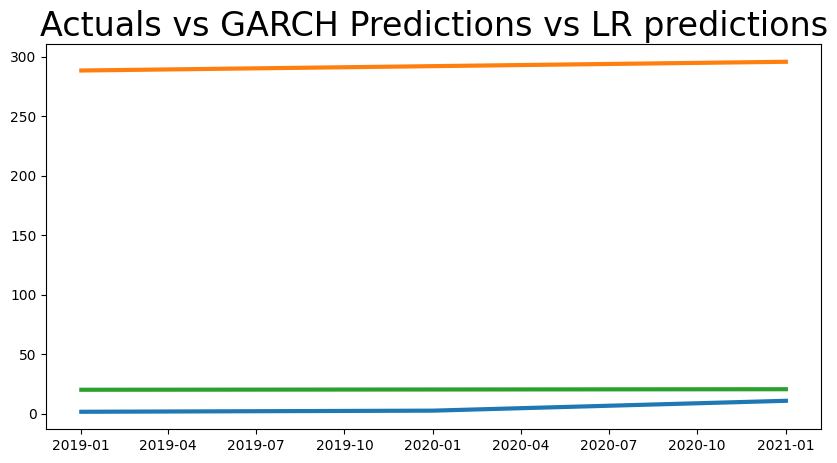

In [1457]:
plt.rcParams["figure.figsize"] = 10, 5

plt.plot(predictions_df_arch["vol"])
plt.plot(predictions_df_arch["Predictions"])
plt.plot(pd.Series(lr_predict, index=y_test.index))

plt.title("Actuals vs GARCH Predictions vs LR predictions", size=24)

plt.show()

In [1458]:
mean_squared_error(
    predictions_df_arch["vol"].abs(), pd.Series(lr_predict, index=y_test.index)
)

251.4089377647131

Краткий вывод: Проанализировав волатильность временного ряда с ВВП и построив GARCH модель мы получили неудовлетворительный результат, так как модель совсем не уловила дисперсию. Удивительным оказалось, что простая модель линейной регрессии показала значительно лучший результат: MSE для GARCH составила 82532, а для линейной регрессии - 251. Возможно, что причиной такого плохого результата у GARCH модели стало малое количество данных.